In [2]:
%pwd

'C:\\Users\\big_u\\DIX MA Testing Backtrader'

In [3]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt
import backtrader.indicators as btind

from backtrader.feeds import GenericCSVData

In [4]:
class dix_csv(GenericCSVData):
    
    lines= ('dix', 'gex')
    
    params = (
        ('dtformat', '%m/%d/%Y'),
        ('datetime', 0),
        ('time', -1),
        ('open', 1),
        ('high', 2),
        ('low', 3),
        ('close', 4),
        ('volume', 6),
        ('openinterest', -1),
        ('dix', 9),
        ('gex', 10),        
    )

In [5]:
#buy at beginning of data and hold
class BuyAndHold_1(bt.Strategy):
    def start(self):
        self.val_start = self.broker.get_cash()  # keep the starting cash

    def nextstart(self):
        # Buy all the available cash
        size = int(self.broker.get_cash() / self.data)
        self.buy(size=size)

    def stop(self):
        # calculate the actual returns
        self.roi = (self.broker.get_value() / self.val_start) - 1.0
        print('ROI:        {:.2f}%'.format(100.0 * self.roi))

In [6]:
#run buy and hold strategy
if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()    
    
    # Add a strategy
    cerebro.addstrategy(BuyAndHold_1)
    
    
    # Datas are in a subfolder of the samples. Need to find where the script is
    # because it could have been called from anywhere
    modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
    datapath = os.path.join(modpath, 'C:\\Users\\big_u\\DIX MA Testing Backtrader\DIX OHLC.csv')

    # Create a Data Feed
    data = dix_csv(
        dataname=datapath,
    )

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(100000.0)

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=1)

    # Print out the starting conditions
    #print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()
    
    # Set the commission
    cerebro.broker.setcommission(commission=0.00)

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())


ROI:        129.23%
Final Portfolio Value: 229228.25


<IPython.core.display.Javascript object>


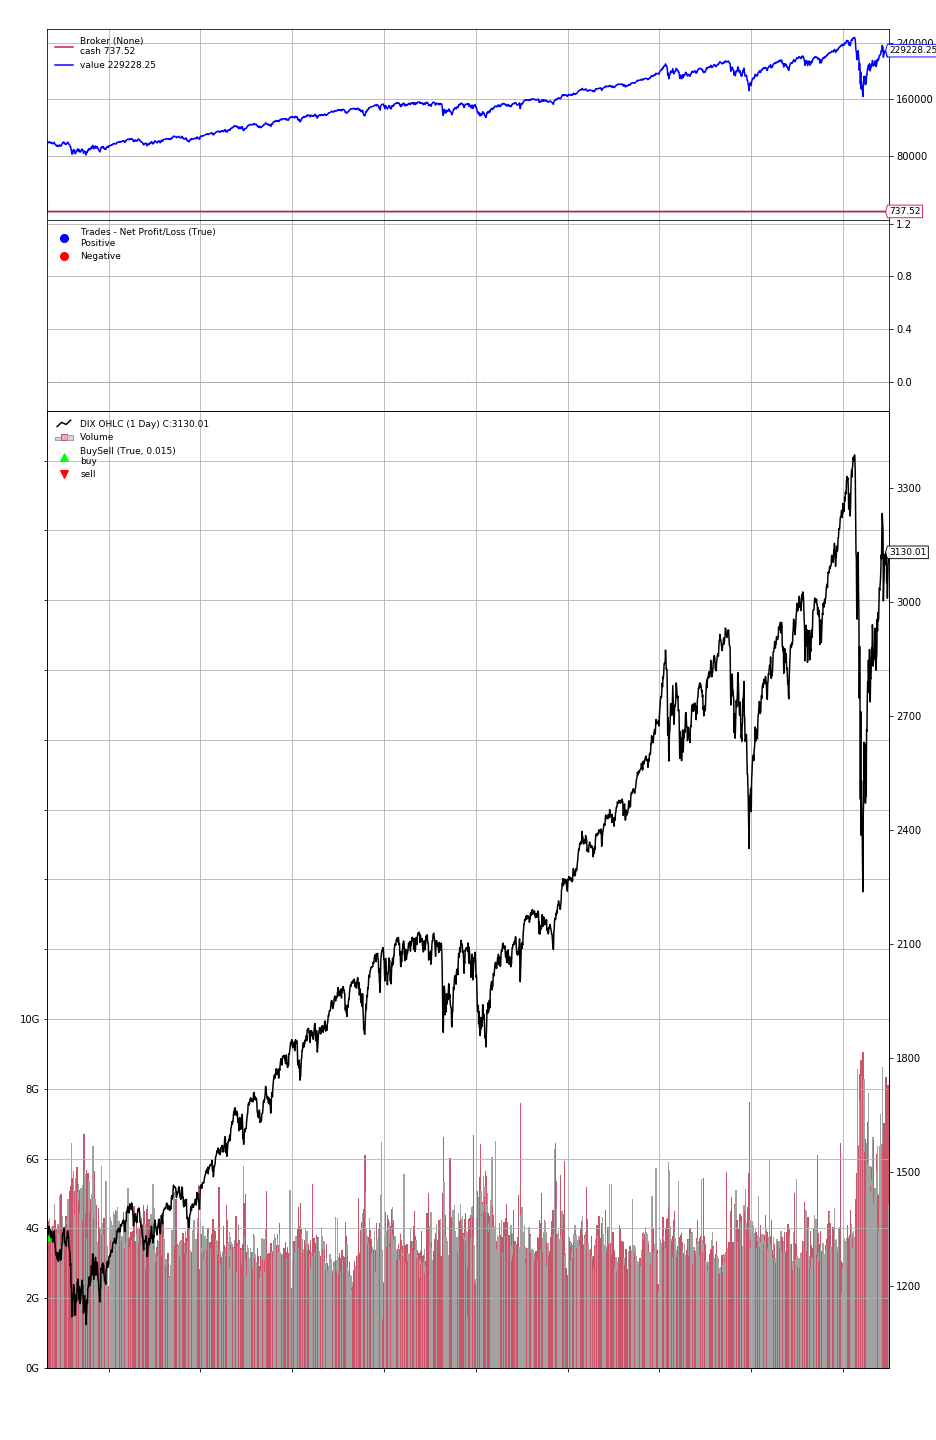

[[<Figure size 936x1440 with 4 Axes>]]

In [8]:
%matplotlib inline
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 13, 20  # that's default image size for this interactive session
pylab.rcParams['font.family'] = 'sans-serif'
pylab.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
pylab.rcParams['font.serif'] = ['Bitstream Vera Sans']
# Plot the result
cerebro.plot()

In [9]:
#Create a Strategy DIX no MAs
class TestStrategy(bt.Strategy):
    params = (
        ('period', 3),
        ('printlog', True),
        ('dixupper', 46),
        ('dixlower', 40),
    )

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function fot this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add a DIXSMA Indicator
        #self.dixsma = bt.indicators.sma(
        #    self.data.dix, period=self.params.period)


    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        #self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # buy when dix greater than dixupper threshold
            if self.data.dix >= (self.params.dixupper/100):
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                self.order = self.buy()
                
        else:
            
            # sell when DIX less than dixlower threshold
            self.duration = len(self) - self.bar_executed + 1
            if self.data.dix <= (self.params.dixlower/100):
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()
    def stop(self):
        self.log('(Period %2d) Ending Value %.2f' %
                 (self.params.period, self.broker.getvalue()), doprint=True)

In [10]:
#DIX Strategy no MA run
if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()    
    
    # Add a strategy
    cerebro.addstrategy(TestStrategy)
    
    
    # Datas are in a subfolder of the samples. Need to find where the script is
    # because it could have been called from anywhere
    modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
    datapath = os.path.join(modpath, 'C:\\Users\\big_u\\DIX MA Testing Backtrader\DIX OHLC.csv')

    # Create a Data Feed
    data = dix_csv(
        dataname=datapath,
    )

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(100000.0)

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=1)

    # Print out the starting conditions
    #print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()
    
    # Set the commission
    cerebro.broker.setcommission(commission=0.00)

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())


2011-08-10, BUY CREATE, 1120.76
2011-08-11, BUY EXECUTED, Price: 1121.30, Cost: 1121.30, Comm 0.00
2011-10-27, SELL CREATE, 1284.59
2011-10-28, SELL EXECUTED, Price: 1284.39, Cost: 1121.30, Comm 0.00
2011-10-28, OPERATION PROFIT, GROSS 163.09, NET 163.09
2011-11-04, BUY CREATE, 1253.23
2011-11-07, BUY EXECUTED, Price: 1253.21, Cost: 1253.21, Comm 0.00
2012-04-20, SELL CREATE, 1378.53
2012-04-23, SELL EXECUTED, Price: 1378.53, Cost: 1253.21, Comm 0.00
2012-04-23, OPERATION PROFIT, GROSS 125.32, NET 125.32
2012-05-23, BUY CREATE, 1318.86
2012-05-24, BUY EXECUTED, Price: 1318.72, Cost: 1318.72, Comm 0.00
2012-07-03, SELL CREATE, 1374.02
2012-07-05, SELL EXECUTED, Price: 1373.72, Cost: 1318.72, Comm 0.00
2012-07-05, OPERATION PROFIT, GROSS 55.00, NET 55.00
2012-07-20, BUY CREATE, 1362.66
2012-07-23, BUY EXECUTED, Price: 1362.34, Cost: 1362.34, Comm 0.00
2012-08-03, SELL CREATE, 1390.99
2012-08-06, SELL EXECUTED, Price: 1391.04, Cost: 1362.34, Comm 0.00
2012-08-06, OPERATION PROFIT, GROSS 2

<IPython.core.display.Javascript object>


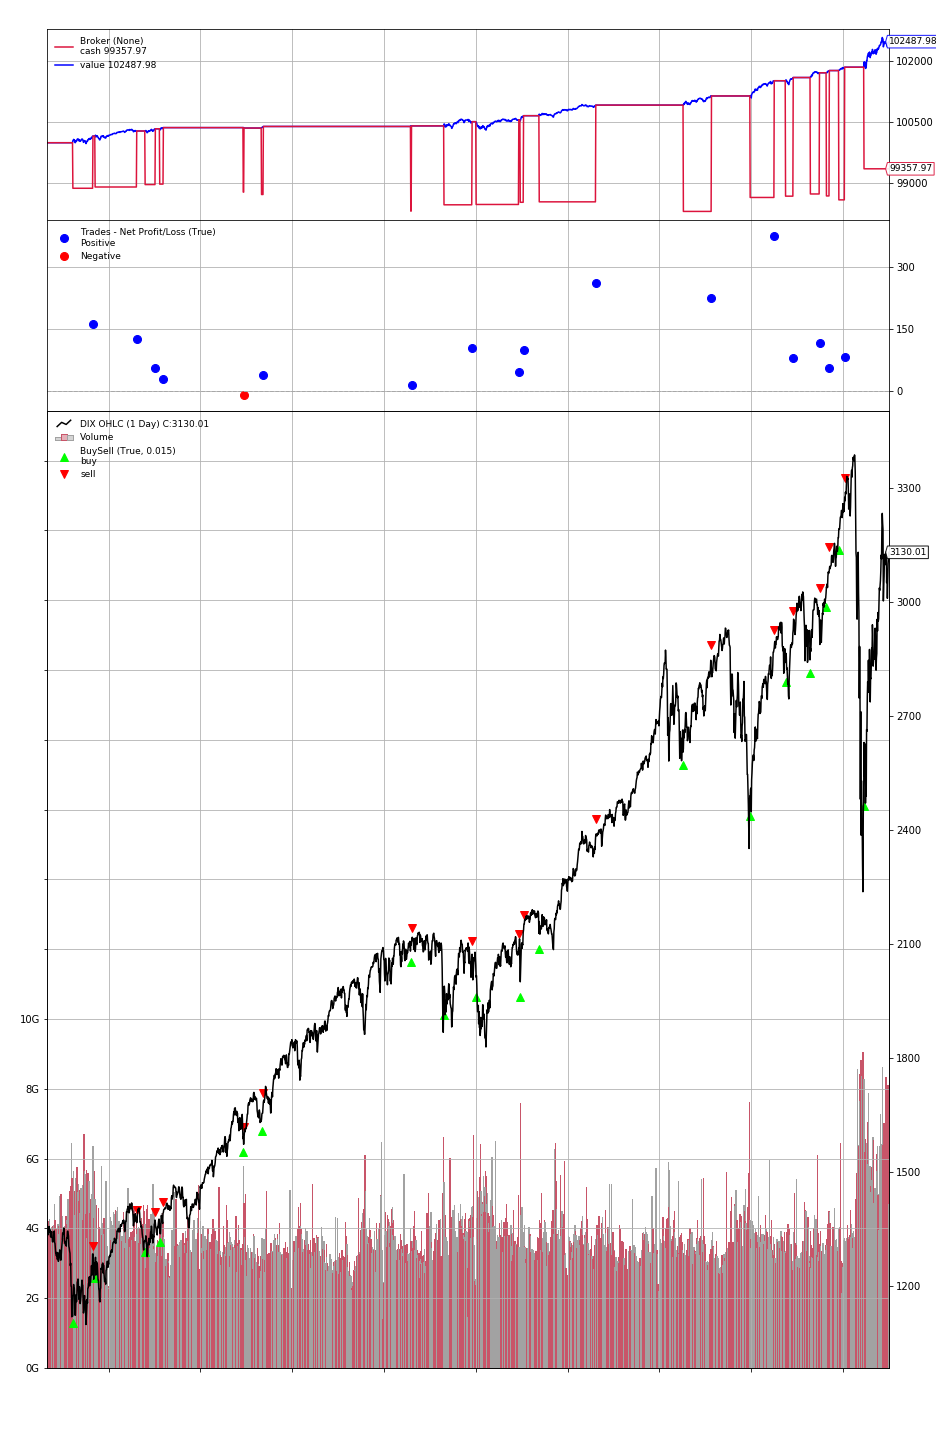

[[<Figure size 936x1440 with 4 Axes>]]

In [11]:
%matplotlib inline
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 13, 20  # that's default image size for this interactive session
pylab.rcParams['font.family'] = 'sans-serif'
pylab.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
pylab.rcParams['font.serif'] = ['Bitstream Vera Sans']
# Plot the result
cerebro.plot()

In [10]:
##OPTIMIZE DIX Thresholds
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])


# Import the backtrader platform
import backtrader as bt
import backtrader.indicators as btind


#Create a Strategy
class DIXOptStrategy(bt.Strategy):
    params = (
        ('period', 3),
        ('printlog', False),
        ('dixupper', 45),
        ('dixlower', 40),
    )

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function fot this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add a DIXSMA Indicator
        #self.dixsma = bt.indicators.sma(
        #    self.data.dix, period=self.params.period)


    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        #self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # buy when dix greater than dixupper threshold
            if self.data.dix >= (self.params.dixupper/100):
                #self.log('BUY CREATE, %.2f' % self.dataclose[0])
                self.order = self.buy()
                
        else:
            
            # sell when DIX less than dixlower threshold
            self.duration = len(self) - self.bar_executed + 1
            if self.data.dix <= (self.params.dixlower/100):
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

    def stop(self):
        self.log('(DIXUpper %2d) (DIXLower%2d) Ending Value %.2f' %
                 (self.params.dixupper, self.params.dixlower, self.broker.getvalue()), doprint=True)


if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    strats = cerebro.optstrategy(
        DIXOptStrategy,
        dixupper=range(41,51),
        dixlower=range(34,43)) 

    # Datas are in a subfolder of the samples. Need to find where the script is
    # because it could have been called from anywhere
    modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
    datapath = os.path.join(modpath, 'C:\\Users\\big_u\\DIX MA Testing Backtrader\DIX OHLC.csv')

    # Create a Data Feed
    data = dix_csv(
        dataname=datapath,
    )


    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(100000.0)

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=1)

    # Set the commission
    cerebro.broker.setcommission(commission=0.0)

    # Run over everything
    cerebro.run(maxcpus=1)

2020-07-02, (DIXUpper 41) (DIXLower34) Ending Value 101717.11
2020-07-02, (DIXUpper 41) (DIXLower35) Ending Value 101717.06
2020-07-02, (DIXUpper 41) (DIXLower36) Ending Value 101771.46
2020-07-02, (DIXUpper 41) (DIXLower37) Ending Value 101373.76
2020-07-02, (DIXUpper 41) (DIXLower38) Ending Value 101661.30
2020-07-02, (DIXUpper 41) (DIXLower39) Ending Value 102074.32
2020-07-02, (DIXUpper 41) (DIXLower40) Ending Value 101937.71
2020-07-02, (DIXUpper 41) (DIXLower41) Ending Value 101824.74
2020-07-02, (DIXUpper 41) (DIXLower42) Ending Value 101919.47
2020-07-02, (DIXUpper 42) (DIXLower34) Ending Value 101885.42
2020-07-02, (DIXUpper 42) (DIXLower35) Ending Value 101885.37
2020-07-02, (DIXUpper 42) (DIXLower36) Ending Value 101720.84
2020-07-02, (DIXUpper 42) (DIXLower37) Ending Value 101646.60
2020-07-02, (DIXUpper 42) (DIXLower38) Ending Value 101945.84
2020-07-02, (DIXUpper 42) (DIXLower39) Ending Value 102212.14
2020-07-02, (DIXUpper 42) (DIXLower40) Ending Value 102130.50
2020-07-

In [20]:
#Create a Strategy DIX MA
class TestStrategyDIXma(bt.Strategy):
    params = (
        ('period', 1),
        ('printlog', True),
        ('dixupper', 46),
        ('dixlower', 39),
    )

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function fot this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        #Add a DIXSMA Indicator
        self.dixsma = bt.indicators.MovingAverageSimple(
           self.data.dix, period=self.params.period, subplot=True)
        btind.SMA(self.data.dix, period=1, subplot=True)


    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        #self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # buy when dix greater than dixupper threshold
            if self.dixsma >= (self.params.dixupper/100):
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                self.order = self.buy()
                
        else:
            
            # sell when DIX less than dixlower threshold
            self.duration = len(self) - self.bar_executed + 1
            if self.dixsma <= (self.params.dixlower/100):
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()
    def stop(self):
        self.log('(Period %2d) Ending Value %.2f' %
                 (self.params.period, self.broker.getvalue()), doprint=True)

In [21]:
#runDIXma Strategy
if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()    
    
    # Add a strategy
    cerebro.addstrategy(TestStrategyDIXma)
    
    
    # Datas are in a subfolder of the samples. Need to find where the script is
    # because it could have been called from anywhere
    modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
    datapath = os.path.join(modpath, 'C:\\Users\\big_u\\DIX MA Testing Backtrader\DIX OHLC.csv')

    # Create a Data Feed
    data = dix_csv(
        dataname=datapath,
    )

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(100000.0)

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=1)

    # Print out the starting conditions
    #print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()
    
    # Set the commission
    cerebro.broker.setcommission(commission=0.00)

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())


2011-08-10, BUY CREATE, 1120.76
2011-08-11, BUY EXECUTED, Price: 1121.30, Cost: 1121.30, Comm 0.00
2012-09-11, SELL CREATE, 1433.56
2012-09-12, SELL EXECUTED, Price: 1433.56, Cost: 1121.30, Comm 0.00
2012-09-12, OPERATION PROFIT, GROSS 312.26, NET 312.26
2013-06-20, BUY CREATE, 1588.19
2013-06-21, BUY EXECUTED, Price: 1588.62, Cost: 1588.62, Comm 0.00
2013-06-24, SELL CREATE, 1573.09
2013-06-25, SELL EXECUTED, Price: 1577.52, Cost: 1588.62, Comm 0.00
2013-06-25, OPERATION PROFIT, GROSS -11.10, NET -11.10
2013-08-30, BUY CREATE, 1632.97
2013-09-03, BUY EXECUTED, Price: 1635.95, Cost: 1635.95, Comm 0.00
2013-09-16, SELL CREATE, 1697.60
2013-09-17, SELL EXECUTED, Price: 1697.73, Cost: 1635.95, Comm 0.00
2013-09-17, OPERATION PROFIT, GROSS 61.78, NET 61.78
2015-04-17, BUY CREATE, 2081.18
2015-04-20, BUY EXECUTED, Price: 2084.11, Cost: 2084.11, Comm 0.00
2015-05-08, SELL CREATE, 2116.10
2015-05-11, SELL EXECUTED, Price: 2115.56, Cost: 2084.11, Comm 0.00
2015-05-11, OPERATION PROFIT, GROSS 3

<IPython.core.display.Javascript object>


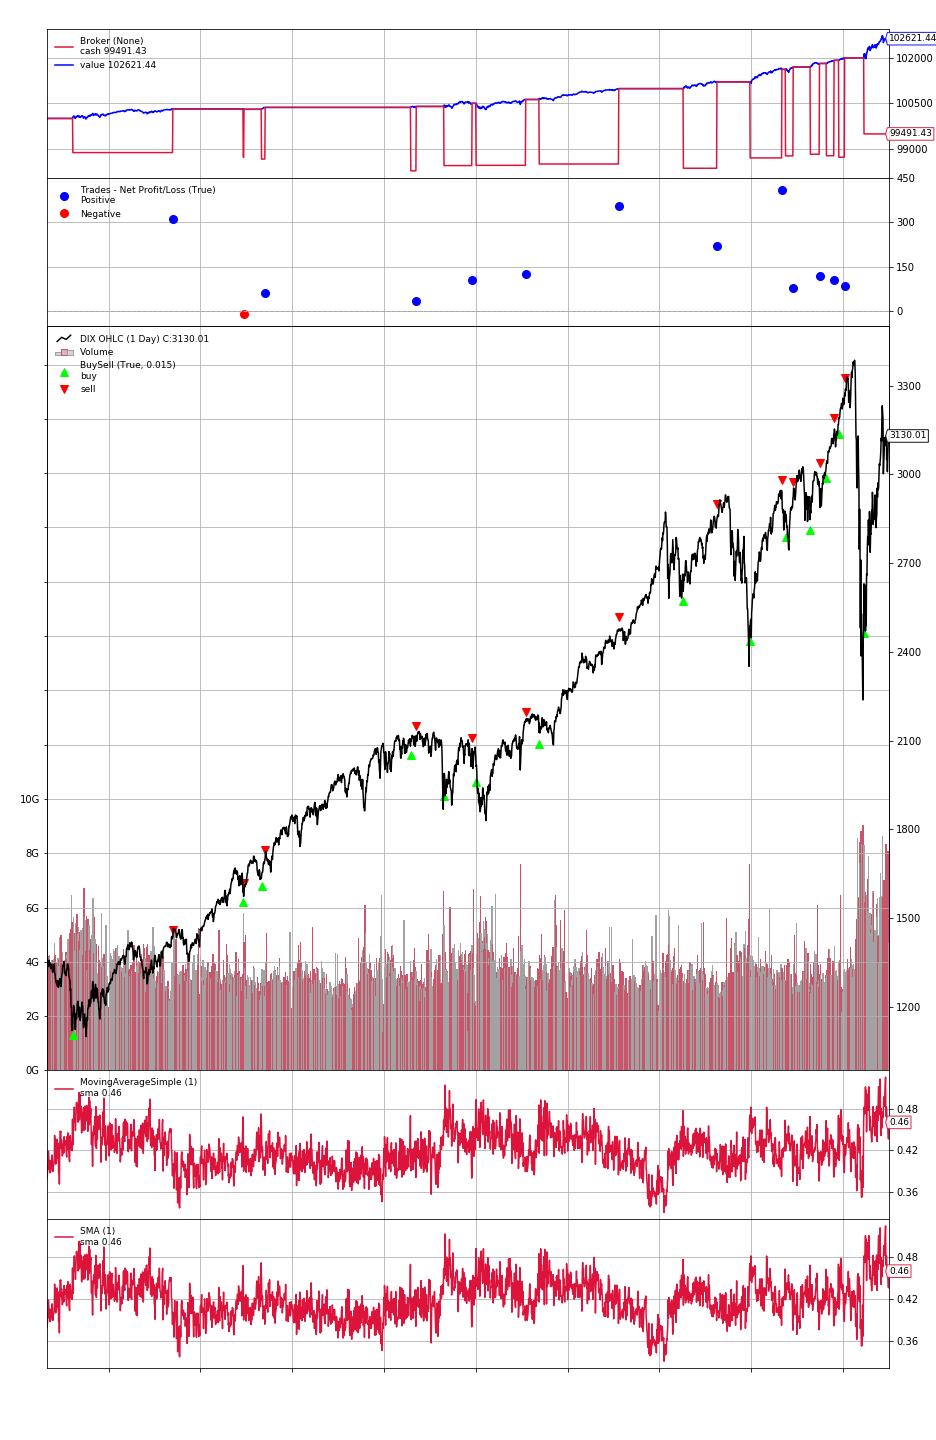

[[<Figure size 936x1440 with 6 Axes>]]

In [22]:
%matplotlib inline
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 13, 20  # that's default image size for this interactive session
pylab.rcParams['font.family'] = 'sans-serif'
pylab.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
pylab.rcParams['font.serif'] = ['Bitstream Vera Sans']
# Plot the result
cerebro.plot()

In [ ]:
#Optimize DIX MA
class DIXmaopt(bt.Strategy):
    params = (
        ('period', 2),
        ('printlog', True),
        ('dixupper', 46),
        ('dixlower', 40),
    )

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function fot this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        #Add a DIXSMA Indicator
        self.dixsma = bt.indicators.MovingAverageSimple(
           self.data.dix, period=self.params.period, subplot=True)
        btind.SMA(self.data.dix, period=1, subplot=True)


    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # buy when dix greater than dixupper threshold
            if self.dixsma >= (self.params.dixupper/100):
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                self.order = self.buy()
                
        else:
            
            # sell when DIX less than dixlower threshold
            self.duration = len(self) - self.bar_executed + 1
            if self.dixsma <= (self.params.dixlower/100):
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()
    def stop(self):
        self.log('(DIXUpper %2d) (DIXLower%2d) (MA Period%2d) Ending Value %.2f' %
                 (self.params.dixupper, self.params.dixlower, self.params.self.broker.getvalue()), doprint=True)
        
#runDIXma Strategy Opt
if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()    
    
    # Add a strategy
    strats = cerebro.optstrategy(
        DIXmaopt,
        period=range(1,10),
        dixupper=range(41,51),
        dixlower=range(34,43)) 
    
    
    # Datas are in a subfolder of the samples. Need to find where the script is
    # because it could have been called from anywhere
    modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
    datapath = os.path.join(modpath, 'C:\\Users\\big_u\\DIX MA Testing Backtrader\DIX OHLC.csv')

    # Create a Data Feed
    data = dix_csv(
        dataname=datapath,
    )

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(100000.0)

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=1)

    # Print out the starting conditions
    #print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()
    
    # Set the commission
    cerebro.broker.setcommission(commission=0.00)

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
